In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.head()

,Year,Month,Day,Hour,Min,Sec,Lat,Long,Dist_East_West,Dist_North_South
0,2017,8,27,17,56,9.7207,12.7452,-13.4960,271.5710,138.4600
1,2017,8,27,17,56,19.4011,12.0782,-16.2206,-23.9866,64.2929
2,2017,8,27,17,56,36.8910,9.6958,-8.5119,820.7290,-200.6180
3,2017,8,27,17,56,42.7955,10.8790,-10.6200,587.4700,-69.0520
4,2017,8,27,17,56,46.1723,9.9119,-12.6214,370.0740,-176.5890


In [3]:
def GetHours(x):
    hours = int(x[0:2])
    return hours

def GetMinutes(x):
    minutes = int(x[3:5])
    return minutes

def GetSeconds(x):
    seconds = int(x[6:8])
    return seconds

def GetMicroseconds(x):
    ms = int(x[9:])
    return ms

def GetTotalMinute(x):
    hours = int(x[0:2])
    minutes = int(x[3:5])
    return 60 * hours + minutes

'''print("Rows: ", len(df))
df['Hours'] = df['Time'].apply(GetHours)
df['Minutes'] = df['Time'].apply(GetMinutes)
df['Seconds'] = df['Time'].apply(GetSeconds)
df['MicroSeconds'] = df['Time'].apply(GetMicroseconds)
df['TotalMinutes'] = df['Time'].apply(GetTotalMinute)

df.drop(df[df['TotalMinutes'] <= 30].index, inplace=True)
print("Rows: ", len(df))'''

'print("Rows: ", len(df))\ndf[\'Hours\'] = df[\'Time\'].apply(GetHours)\ndf[\'Minutes\'] = df[\'Time\'].apply(GetMinutes)\ndf[\'Seconds\'] = df[\'Time\'].apply(GetSeconds)\ndf[\'MicroSeconds\'] = df[\'Time\'].apply(GetMicroseconds)\ndf[\'TotalMinutes\'] = df[\'Time\'].apply(GetTotalMinute)\n\ndf.drop(df[df[\'TotalMinutes\'] <= 30].index, inplace=True)\nprint("Rows: ", len(df))'

In [4]:
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)
df.head()

,Year,Month,Day,Hour,Min,Sec,Lat,Long,Dist_East_West,Dist_North_South
0,2017,8,27,17,56,9.7207,12.7452,-13.4960,271.5710,138.4600
1,2017,8,27,17,56,19.4011,12.0782,-16.2206,-23.9866,64.2929
2,2017,8,27,17,56,36.8910,9.6958,-8.5119,820.7290,-200.6180
3,2017,8,27,17,56,42.7955,10.8790,-10.6200,587.4700,-69.0520
4,2017,8,27,17,56,46.1723,9.9119,-12.6214,370.0740,-176.5890


In [5]:
coord_df = df.loc[:,['Lat','Long']]
coord_df.head()

,Lat,Long
0,12.7452,-13.4960
1,12.0782,-16.2206
2,9.6958,-8.5119
3,10.8790,-10.6200
4,9.9119,-12.6214


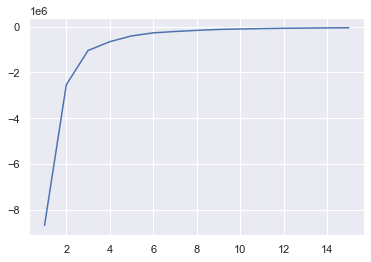

In [6]:
#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()

In [7]:
cluster_df = coord_df
for n_clusters in range(1,16):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
    kmeans.fit(cluster_df)
    inertia = kmeans.inertia_
    print("Cluster count: ", n_clusters, "\tInertia: ", inertia)

Cluster count:  1 	Inertia:  77692757.44658689
Cluster count:  2 	Inertia:  27766031.309542447
Cluster count:  3 	Inertia:  14167410.1702434
Cluster count:  4 	Inertia:  10427540.061424654
Cluster count:  5 	Inertia:  7924242.881342395
Cluster count:  6 	Inertia:  6104484.458057777
Cluster count:  7 	Inertia:  5069461.787262313
Cluster count:  8 	Inertia:  4067920.052782503
Cluster count:  9 	Inertia:  3488664.330819993
Cluster count:  10 	Inertia:  2987939.9408822004
Cluster count:  11 	Inertia:  2627455.287600819
Cluster count:  12 	Inertia:  2316472.458720337
Cluster count:  13 	Inertia:  2104131.1286423216
Cluster count:  14 	Inertia:  1909576.4091840654
Cluster count:  15 	Inertia:  1797277.3354473764


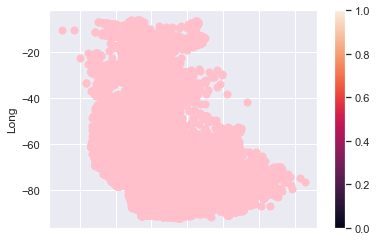

In [8]:
cluster_df.plot.scatter(x='Lat',y='Long', c='pink', s=50, cmap='spring')
plt.show()

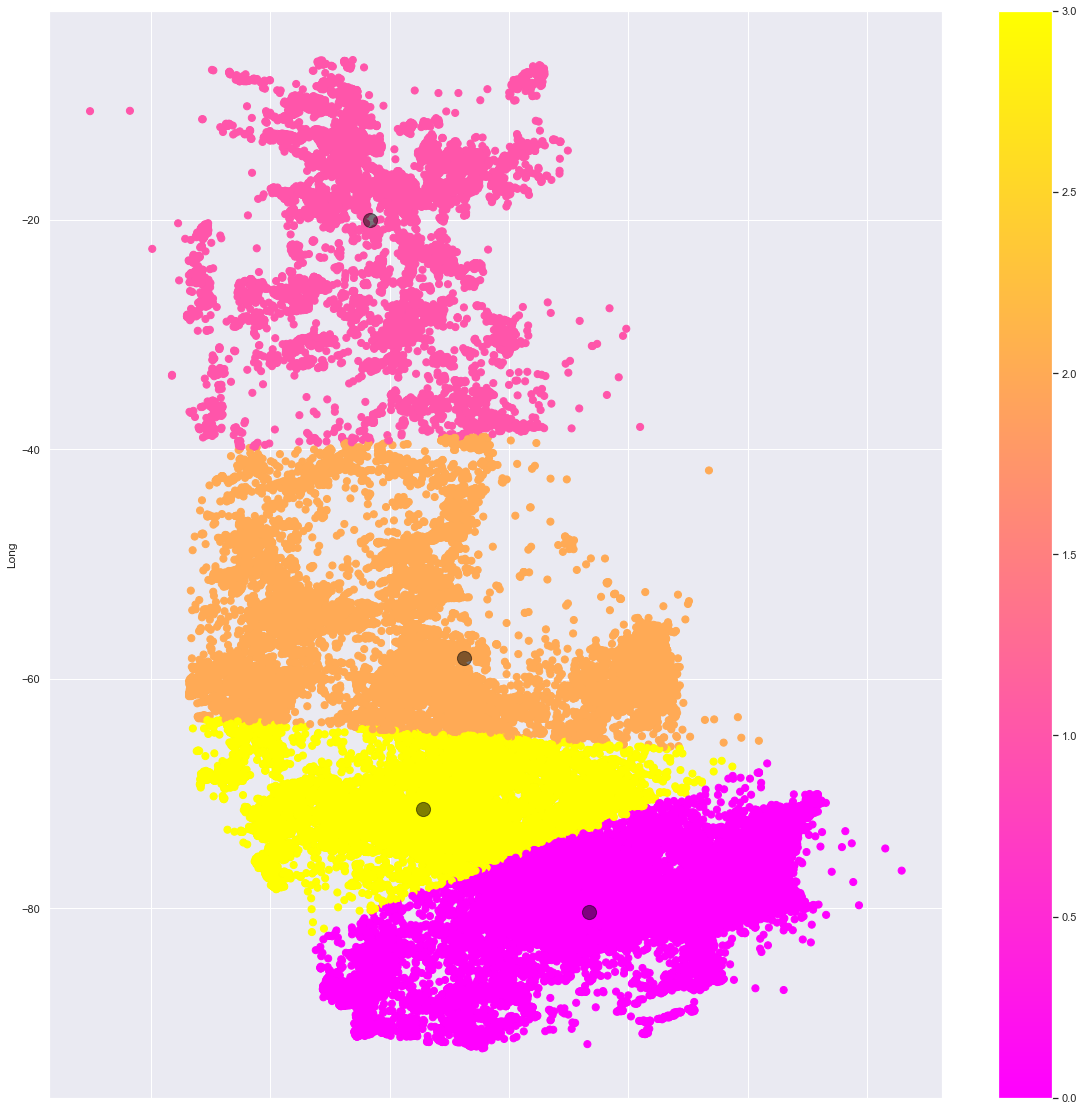

In [9]:
#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()

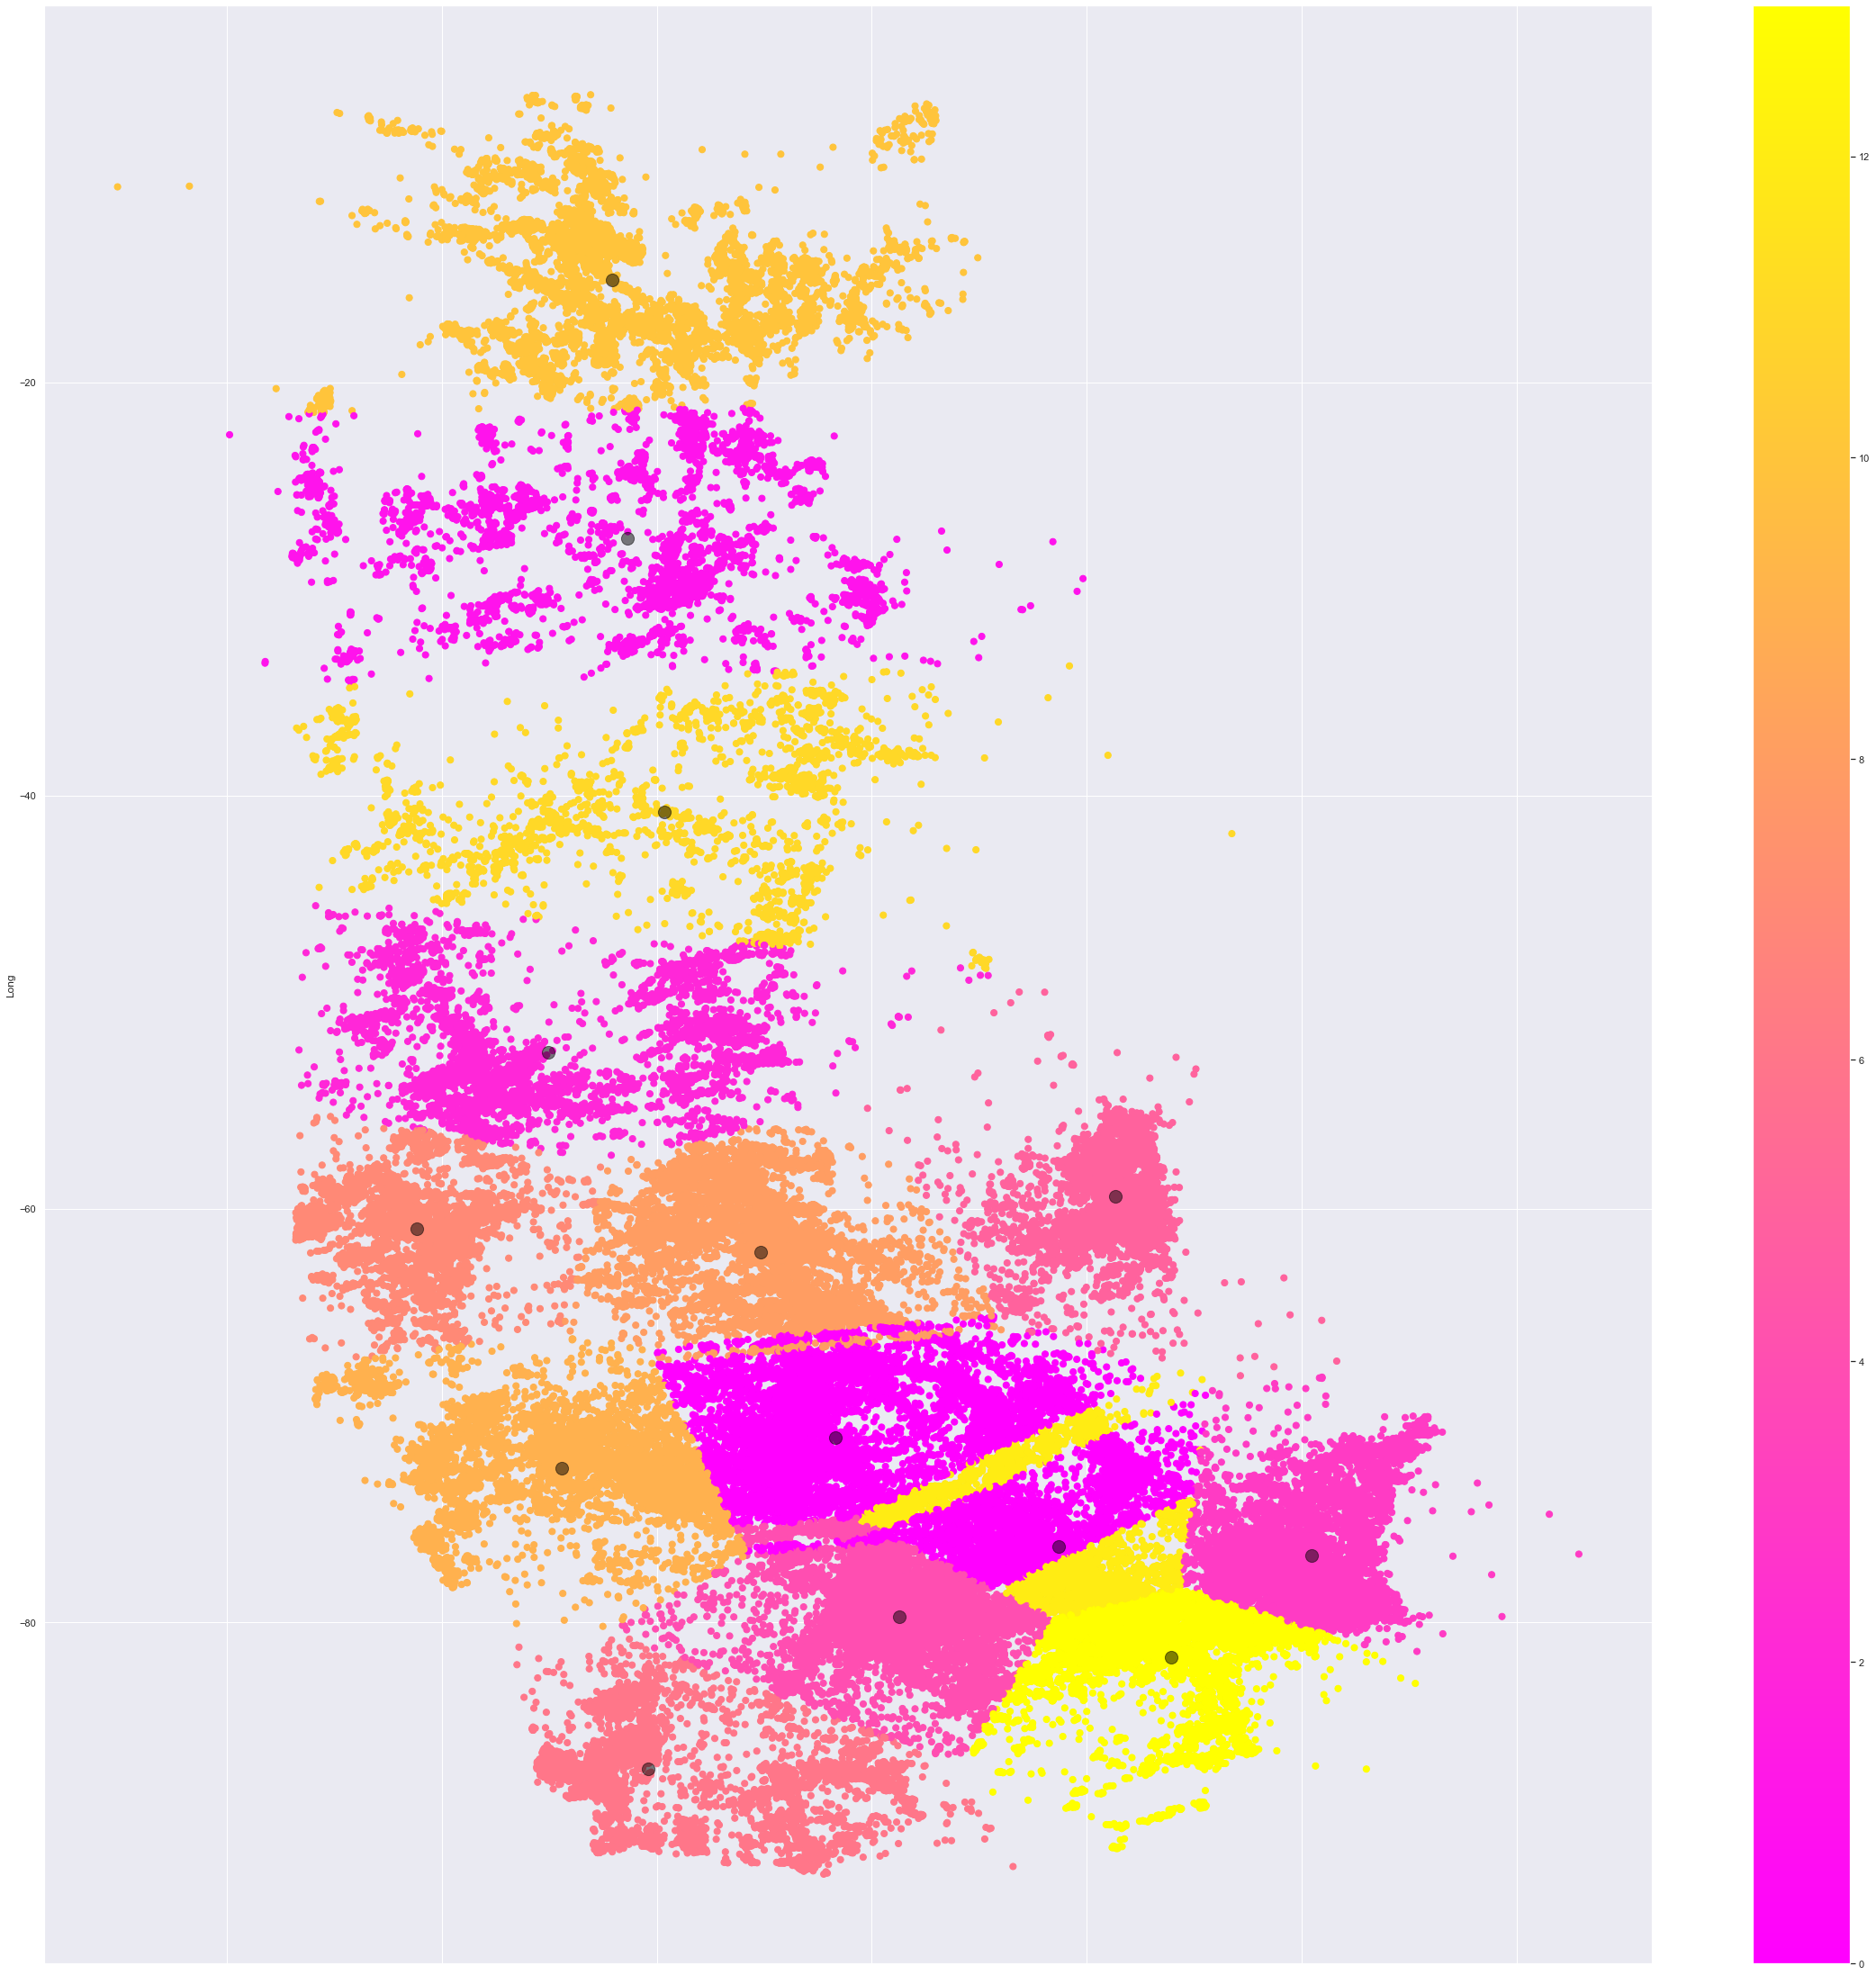

In [10]:
#kmeans using the set cluster count
kmeans = KMeans(n_clusters=14, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(40,40))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()

In [11]:
centers_df = pd.DataFrame(data=centers, columns=["Lat", "Long", "delete"])
centers_df = centers_df.iloc[:,:2]
ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

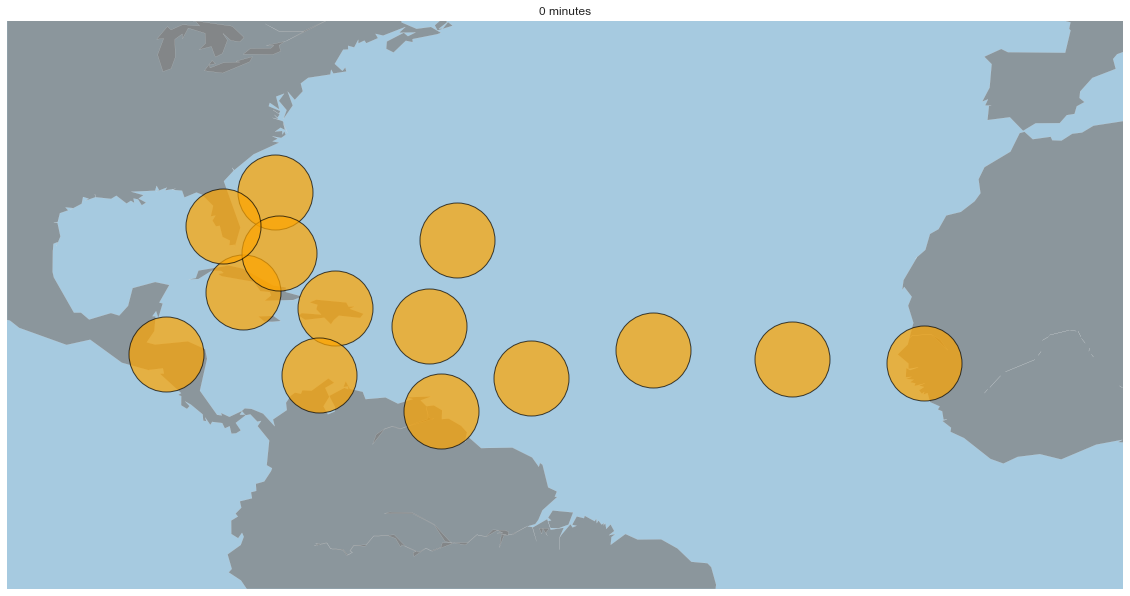

In [12]:
plt.figure(figsize=(20,20))
m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# Plot the lightning data
m.plot(centers_df['Long'], centers_df['Lat'], linestyle='none', marker="o", markersize=75, alpha=0.7, c="orange", markeredgecolor="black", markeredgewidth=1)
plt.title("0 minutes")
plt.savefig("./data/test",bbox_inches='tight')